# import

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


import sys
sys.executable

In [25]:
import os
os.environ["MKL_NUM_THREADS"] = "2"
os.environ["NUMEXPR_NU M_THREADS"] = "2"
os.environ["OMP_NUM_THREADS"] = "2"
import time
import pprint
from typing import Union

import numpy
from torchsummary import summary

import torch
from torch.cuda import empty_cache
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.cuda.amp import autocast
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader

In [1]:
from SSL.util.loaders import load_dataset, load_optimizer, load_callbacks, load_preprocesser
from SSL.util.model_loader import load_model
from SSL.util.checkpoint import CheckPoint, mSummaryWriter
from SSL.util.utils import reset_seed, get_datetime, track_maximum, DotDict
from SSL.ramps import Warmup, sigmoid_rampup
from SSL.losses import JensenShanon

from metric_utils.metrics import BinaryAccuracy, FScore, ContinueAverage

In [27]:
import augmentation_utils.spec_augmentations as sa

In [34]:
import argparse
parser = argparse.ArgumentParser()
parser.add_argument("--from_config", default="", type=str)
parser.add_argument("-d", "--dataset_root", default="../../datasets", type=str)
parser.add_argument("-D", "--dataset", default="esc10", type=str)

group_t = parser.add_argument_group("Commun parameters")
group_t.add_argument("-m", "--model", default="wideresnet28_2", type=str)
group_t.add_argument("--supervised_ratio", default=0.1, type=float)
group_t.add_argument("--batch_size", default=64, type=int)
group_t.add_argument("--nb_epoch", default=150, type=int)
group_t.add_argument("--learning_rate", default=0.001, type=float)
group_t.add_argument("--resume", action="store_true", default=False)
group_t.add_argument("--seed", default=1235, type=int)

group_m = parser.add_argument_group("Model parameters")
# group_m.add_argument("--num_classes", default=10, type=int)

group_u = parser.add_argument_group("Datasets parameters")
group_u.add_argument("-t", "--train_folds", nargs="+", default=[1, 2, 3, 4], type=int)
group_u.add_argument("-v", "--val_folds", nargs="+", default=[5], type=int)

group_s = parser.add_argument_group("Student teacher parameters")
group_s.add_argument("--ema_alpha", default=0.999, type=float)
group_s.add_argument("--warmup_length", default=50, type=int)
group_s.add_argument("--lambda_cost_max", default=1, type=float)
group_s.add_argument("--teacher_perturb_fn", default="identity", type=str)
group_s.add_argument("--ccost_softmax", action="store_false", default=True)
group_s.add_argument("--ccost_method", type=str, default="mse")
group_s.add_argument("--mixup_alpha", default=0.4, type=float)

group_l = parser.add_argument_group("Logs")
group_l.add_argument("--checkpoint_root", default="../model_save/", type=str)
group_l.add_argument("--tensorboard_root", default="../tensorboard/", type=str)
group_l.add_argument("--checkpoint_path", default="mean-teacher_mixup", type=str)
group_l.add_argument("--tensorboard_path", default="mean-teacher_mixup", type=str)
group_l.add_argument("--tensorboard_sufix", default="", type=str)

args=parser.parse_args("")

tensorboard_path = os.path.join(args.tensorboard_root, args.dataset, args.tensorboard_path)
checkpoint_path = os.path.join(args.checkpoint_root, args.dataset, args.checkpoint_path)

## Basic verification

In [35]:
available_datasets = ["esc10", "ubs8k", "speechcommand", "speechcommand10"]
available_models = ["cnn03", "wideresnet28_2", "wideresnet28_4", "wideresnet28_8"]
available_ccost_method = ["mse", "js"]

assert args.dataset.lower() in available_datasets
assert args.model.lower() in available_models
assert args.ccost_method.lower() in available_ccost_method

In [36]:
pprint.pprint(vars(args))

{'batch_size': 256,
 'ccost_method': 'mse',
 'ccost_softmax': True,
 'checkpoint_path': 'mean-teacher_mixup',
 'checkpoint_root': '../model_save/',
 'dataset': 'SpeechCommand10',
 'dataset_root': '../../datasets',
 'ema_alpha': 0.999,
 'from_config': '',
 'lambda_cost_max': 1,
 'learning_rate': 0.001,
 'mixup_alpha': 0.4,
 'model': 'wideresnet28_2',
 'nb_epoch': 150,
 'num_classes': 10,
 'resume': False,
 'seed': 1235,
 'supervised_ratio': 0.1,
 'teacher_perturb_fn': 'identity',
 'tensorboard_path': 'mean-teacher_mixup',
 'tensorboard_root': '../tensorboard/',
 'tensorboard_sufix': '',
 'train_folds': [1, 2, 3, 4],
 'val_folds': [5],
 'warmup_length': 50}


# initialisation

In [37]:
reset_seed(args.seed)

In [39]:
from SSL.trainers.trainers import Trainer

class MeanTeacherTrainer(Trainer):
    def __init__(self, model: str, dataset: str,
                 ema_alpha: float = 0.999,
                 teacher_noise_db: int = 0,
                 warmup_length: int = 50,
                 lambda_ccost_max: float = 1,
                 use_softmax: bool = False,
                 ccost_method: str = "mse"):

        super().__init__(model, "mean-teacher", dataset)

        self.ema_alpha = ema_alpha
        self.teacher_noise_db = teacher_noise_db
        self.warmup_length = warmup_length
        self.lambda_ccost_max = lambda_ccost_max
        self.use_softmax = use_softmax
        self.ccost_method = ccost_method

        self.extra_hparams = dict(
            ema_alpha=self.ema_alpha,
            teacher_noise_db=self.teacher_noise_db,
            warmup_length=self.warmup_length,
            lambda_ccost_max=self.lambda_ccost_max,
            use_softmax=self.use_softmax,
            ccost_method=self.use_softmax,
        )

        self.activation_fn = lambda x: x
        if self.use_softmax:
            self.activation_fn = nn.Sigmoid()

trainer = MeanTeacherTrainer(args.model, args.dataset, use_softmax=True)

# Prepare the dataset

In [40]:
trainer.load_transforms()

Load the transformation


In [41]:
from types import MethodType

def _get_input_shape(self):
    return tuple(self.train_loader._iterables[0].dataset[0][0].shape)

trainer._get_input_shape = MethodType(_get_input_shape, trainer)

In [42]:
parameters = dict(
    dataset=args.dataset,

    dataset_root = args.dataset_root,
    supervised_ratio = args.supervised_ratio,
    batch_size = args.batch_size,
    nb_epoch=args.nb_epoch,
    train_folds = args.train_folds,
    val_folds = args.val_folds,
    
    num_workers=0,
    pin_memory=True,

    verbose = 2,
)

trainer.load_dataset(parameters)

Load the dataset
../../datasets/SpeechCommands/speech_commands_v0.02
Dataset already download and verified
0 out of 6278 junk files were drop.
Silence class already processed
2400 samples present
../../datasets/SpeechCommands/speech_commands_v0.02
Dataset already download and verified
50288 out of 54074 junk files were drop.
Silence class already processed
2400 samples present
../../datasets/SpeechCommands/speech_commands_v0.02
100%|██████████| 35/35 [00:00<00:00, 1781.52it/s]


In [43]:
for S, U in trainer.train_loader:
    x, y = S
    print(x.shape)
    print(y.shape)
    print(y.max())
    break

torch.Size([25, 64, 32])
torch.Size([25])
tensor(11)


# Prep model

In [48]:
def create_model(self):
    print("Creating teacher and student model ...")
    empty_cache()

    model_func = load_model(self.dataset, self.model_str)
    model_params = dict(
        input_shape=self.input_shape,
        num_classes=self.num_classes,
    )

    self.student = model_func(**model_params)
    self.teacher = model_func(**model_params)

    self.student = self.student.cuda()
    self.teacher = self.teacher.cuda()

    # We do not need gradient for the teacher model
    for p in teacher.parameters():
        p.detach()

    summary(self.student, self.input_shape)

trainer.create_model = MethodType(create_model, trainer)

In [49]:
trainer.create_model()

Creating teacher and student model ...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 32]             864
       BatchNorm2d-2           [-1, 32, 64, 32]              64
              ReLU-3           [-1, 32, 64, 32]               0
         MaxPool2d-4           [-1, 32, 32, 16]               0
            Conv2d-5           [-1, 32, 32, 16]           9,216
       BatchNorm2d-6           [-1, 32, 32, 16]              64
              ReLU-7           [-1, 32, 32, 16]               0
            Conv2d-8           [-1, 32, 32, 16]           9,216
       BatchNorm2d-9           [-1, 32, 32, 16]              64
             ReLU-10           [-1, 32, 32, 16]               0
       BasicBlock-11           [-1, 32, 32, 16]               0
           Conv2d-12           [-1, 32, 32, 16]           9,216
      BatchNorm2d-13           [-1, 32, 32, 16]              64


# Training initalization
## Losses

In [50]:
def init_loss(self, parameters: DotDict):
    self.loss_ce = nn.CrossEntropyLoss(reduction="mean")
    self.loss_ce = nn.BCEWithLogitsLoss(reduction="mean")

    if self.ccost_method.lower() == "mse":
        self.loss_cc = nn.MSELoss(reduction="mean")
    elif self.ccost_method.lower() == "js":
        self.loss_cc = JensenShanon

trainer.init_loss = MethodType(init_loss, trainer)

In [51]:
trainer.init_loss(DotDict())

## Optimizer

In [52]:
def init_optimizer(self, parameters: DotDict):
    print("Initialize optimizer")
    self.optimizer = load_optimizer(
        self.dataset,
        self.framework,
        learning_rate=parameters.learning_rate,
        student=self.student,
    )

trainer.init_optimizer = MethodType(init_optimizer, trainer)

In [53]:
parameters = DotDict(
    learning_rate=args.learning_rate
)

trainer.init_optimizer(parameters)

Initialize optimizer


## Callbacks

In [54]:
def init_callbacks(self, parameters: DotDict):
    print("Initialize callbacks")
    self.callbacks = load_callbacks(
        self.dataset,
        self.framework,
        optimizer=self.optimizer,
        nb_epoch=parameters.nb_epoch,
    )

    self.lambda_ccost = Warmup(self.lambda_ccost_max, self.warmup_length, sigmoid_rampup)
    self.callbacks += [self.lambda_ccost]

trainer.init_callbacks = MethodType(init_callbacks, trainer)

In [55]:
parameters=DotDict(
    nb_epoch=args.nb_epoch,
    optimizer=trainer.optimizer,
)
trainer.init_callbacks(parameters)

Initialize callbacks


## Logs

In [56]:
def init_logs(self, parameters: DotDict):
    print("Prepare the log system")
    title_element = (
        self.model_str, parameters.supervised_ratio,
        get_datetime(), self.model_str,
        self.ccost_method.upper(), self.use_softmax, self.teacher_noise_db
    )

    tensorboard_title = "%s/%sS/%s_%s_%s_%s-softmax_%s-n" % title_element
    print("tensorboard saved at: ", os.path.join(self.tensorboard_path, tensorboard_title))

    self.tensorboard = mSummaryWriter(log_dir="%s/%s" % (self.tensorboard_path, tensorboard_title))

trainer.init_logs = MethodType(init_logs, trainer)

In [57]:
parameters=DotDict(
    supervised_ratio=args.supervised_ratio
)
trainer.init_logs(parameters)

Prepare the log system
tensorboard saved at:  /home/lcances/sync/Documents_sync/Projet/Semi-Supervised/SSL/trainers/../../tensorboard/SpeechCommand10/mean-teacher/wideresnet28_2/0.1S/2020-12-09_10:35:38_wideresnet28_2_MSE_False-softmax_0-n


## Checkpoint

In [58]:
def init_checkpoint(self, parameters: DotDict):
    print("Prepare the checkpoint system")
    title_element = (
        self.model_str, parameters.supervised_ratio,
        get_datetime(), self.model_str,
        self.ccost_method.upper(), self.use_softmax, self.teacher_noise_db
    )
    
    checkpoint_title = "%s/%sS/%s_%s_%s_%s-softmax_%s-n" % title_element

    self.checkpoint = CheckPoint(
        [self.student, self.teacher], self.optimizer, mode="max",
        name=f"{self.checkpoint_path}/{checkpoint_title}")

trainer.init_checkpoint = MethodType(init_checkpoint, trainer)

In [59]:
# Checkpoint
parameters=DotDict(
    supervised_ratio=args.supervised_ratio
)
trainer.init_checkpoint(parameters)

Prepare the checkpoint system


## Metrics

In [60]:
def init_metrics(self, parameters: DotDict):
    self.metrics = DotDict(
        fscore_ss=FScore(),
        fscore_su=FScore(),
        fscore_ts=FScore(),
        fscore_tu=FScore(),
        acc_ss=(),
        acc_su=BinaryAccuracy(),
        acc_ts=BinaryAccuracy(),
        acc_tu=BinaryAccuracy(),
        avg_Sce=ContinueAverage(),
        avg_Tce=ContinueAverage(),
        avg_ccost=ContinueAverage(),
    )
    self.maximum_tracker = track_maximum()

    self.scores = DotDict()
    for key in self.metrics:
        self.scores[key] = []

trainer.init_metrics = MethodType(init_metrics, trainer)

In [61]:
trainer.init_metrics(DotDict())

## training function

In [62]:
def set_printing_form(self):
    UNDERLINE_SEQ = "\033[1;4m"
    RESET_SEQ = "\033[0m"

    header_form = "{:<8.8} {:<6.6} - {:<6.6} - {:<10.8} {:<8.6} {:<8.6} {:<8.6} {:<8.6} {:<8.6} {:<8.6} | {:<10.8} {:<8.6} {:<8.6} {:<8.6} {:<8.6} {:<8.6} - {:<8.6}"
    value_form  = "{:<8.8} {:<6d} - {:<6d} - {:<10.8} {:<8.4f} {:<8.4f} {:<8.4f} {:<8.4f} {:<8.4f} {:<8.4f} | {:<10.8} {:<8.4f} {:<8.4f} {:<8.4f} {:<8.4f} {:<8.4f} - {:<8.4f}"
    self.header = header_form.format(".               ", "Epoch",  "%", "Student:", "ce", "ccost", "acc_s", "f1_s", "acc_u", "f1_u", "Teacher:", "ce", "acc_s", "f1_s", "acc_u", "f1_u" , "Time")

    self.train_form = value_form
    self.val_form = UNDERLINE_SEQ + value_form + RESET_SEQ

trainer.set_printing_form = MethodType(set_printing_form, trainer)

In [63]:
def _update_teacher_model(self, iteration):
    
    # Use the true average until the exponential average is more correct
    alpha = min(1 - 1 / (iteration + 1), self.ema_alpha)
    
    for param, ema_param in zip(self.student.parameters(), self.teacher.parameters()):
        ema_param.data.mul_(alpha).add_(param.data,  alpha = 1-alpha)

In [64]:
def get_mixup_fn(alpha: float = 0.4):
    def mixup(self, x, y, batch_generator):
        from torch.distributions.beta import Beta

        if alpha == 0.0:
            return x, y

        # get a new batch of sample to perform the mixup
        generator = iter(batch_generator)
        x_, y_ = generator.next()

        # Toward the end of the epoch, the last batch can be incomplete,
        # but the newly fetch batch will not be, so we need to trim
        if x.size()[0] != x_.size()[0]:
            return x, y
            # trunc = x.size()[0]
            # x_ = x_[:trunc]
            # y_ = y_[:trunc]

        beta = Beta(alpha, alpha)
        lambda_ = beta.sample().item() if alpha > 0.0 else 1.0
        lambda_ = max((lambda_, 1 - lambda_))
        mixup.lambda_history.append(lambda_)

        batch_mix = x * lambda_ + x_ * (1.0 - lambda_)
        labels_mix = y * lambda_ + y_ * (1.0 - lambda_)

        return batch_mix, labels_mix

    mixup.lambda_history = []
    return mixup

In [65]:
# aug1 = sa.FractalTimeDropout(ratio=1.0, min_chunk_size=20, min_chunk=1, max_chunk=1, void=True, cut=True)
# aug2 = sa.FractalTimeStretch(ratio=1.0, min_chunk_size=20, )
# aug3 = sa.FractalTimeStretch(ratio=1.0, min_chunk_size=20, max_chunk_size=40)
# aug4 = sa.FractalDropout(1.0, freq_min_chunk_size=1, freq_max_chunk_size=3, freq_max_chunk=1, time_max_chunk=1)
# # _noise_fn = sa.UniformSignNoise(1.0, 0.1, mini=-100, maxi=0)
# # _noise_fn = sa.Noise(1.0, 5, mini=-100, maxi=0)
# _noise_fn = sa.FractalStretch(1.0, freq_min_chunk_size=4, freq_max_chunk_size=8, time_min_chunk_size=16, time_max_chunk_size=48)
_noise_fn = lambda x: x

# if args.teacher_perturb_fn == "identity":
#     _noise_fn = lambda x: x

# else:
#     _noise_fn = eval(args.teacher_perturb_fn)

trainer.extra_hparams["_noise_fn"] = str(_noise_fn)

In [66]:
trainer.extra_hparams["_noise_fn"]

'<function <lambda> at 0x7f5822a149d0>'

In [67]:
trainer._update_teacher_model = MethodType(_update_teacher_model, trainer)

In [68]:
def _calc_metrics(self,
                  ss_logits, su_logits, ts_logits, tu_logits,
                  y_s, y_u) -> Union[DotDict, DotDict]:

    with torch.set_grad_enabled(False):
        S = nn.Softmax(dim=1)
        A = lambda x: torch.argmax(x, dim=1)
        M = self.metrics

        fscores = DotDict(
            ss=M.fscore_ss(S(ss_logits), one_hot_s).mean,
            su=M.fscore_su(S(su_logits), one_hot_u).mean,
            ts=M.fscore_ts(S(ts_logits), one_hot_s).mean,
            tu=M.fscore_tu(S(tu_logits), one_hot_u).mean,
        )

        accs = DotDict(
            ss=M.acc_ss(A(ss_logits), y_s).mean,
            su=M.acc_su(A(su_logits), y_u).mean,
            ts=M.acc_ts(A(ts_logits), y_s).mean,
            tu=M.acc_tu(A(tu_logits), y_u).mean,
        )

        return fscores, accs

trainer._calc_metrics = MethodType(_calc_metrics, trainer)

In [69]:
for i, (S, U) in enumerate(trainer.train_loader):
    x_s, y_s = S
    x_u, y_u = U

    print(x_s.shape)
    print(x_u[:25,:].shape)
    break

torch.Size([25, 64, 32])
torch.Size([25, 64, 32])


In [70]:
def train_fn(self, epoch: int):
    # aliases
    M = self.metrics
    T = self.tensorboard.add_scalar
    nb_batch = len(self.train_loader)

    start_time = time.time()
    print("")

    self.reset_metrics()
    self.student.train()

    for i, (S, U) in enumerate(self.train_loader):
        x_s, y_s = S
        x_u, y_u = U

        # transform ground truth to one hot
        y_s = F.one_hot(y_s, self.num_classes)
        y_u = F.one_hot(y_u, self.num_classes)

        # Apply mixup
        n_x_s, n_y_s = self.mixup_fn(x_s, y_s, self.train_loader._iterables[0])
        n_x_u, n_y_u = self.mixup_fn(x_u, y_u, self.train_loader._iterables[1])

        x_s = x_s.cuda()
        y_s = y_s.cuda()
        n_x_s, n_x_u = n_x_s.cuda(), n_x_u.cuda()
        n_y_s, n_y_u = n_y_s.cuda(), n_y_u.cuda()

        # Predictions
        with autocast(enabled=False):
            ss_logits = self.student(x_s)
            su_logits = self.student(x_u)

            ts_logits = self.teacher(x_s)
            tu_logits = self.teacher(n_x_u)

            # Calculate supervised loss (only student on S)
            loss = self.loss_ce(ss_logits, y_s)

            # Calculate consistency cost (mse(student(x), teacher(x)))
            # x is S + U
            student_logits = torch.cat((ss_logits, su_logits), dim=0)
            teacher_logits = torch.cat((ts_logits, tu_logits), dim=0)
            ccost = self.loss_cc(
                self.activation(su_logits),
                self.activation(tu_logits),
            )

            total_loss = loss + self.lambda_ccost() * ccost

            # If loss contain is Nan, stop training there
            if torch.isnan(total_loss).any():
                raise ValueError("Loss is NaN")

        for p in self.student.parameters():
            p.grad = None
        total_loss.backward()
        self.optimizer.step()

        with torch.set_grad_enabled(False):
            # Teacher prediction (for metrics purpose)
            _teacher_loss = self.loss_ce(ts_logits, y_s)

            # Update teacher
            self._update_teacher_model(epoch*nb_batch + i)

            # Compute the metrics for the student
            fscores, accs = self._calc_metrics(
                ss_logits, su_logits,
                ts_logits, tu_logits,
                y_s, n_y_u,
            )

            # Running average of the two losses
            student_running_loss = M.avg_Sce(loss.item()).mean
            teacher_running_loss = M.avg_Tce(_teacher_loss.item()).mean
            running_ccost = M.avg_ccost(ccost.item()).mean

            # logs
            print(self.train_form.format(
                "Training: ", epoch + 1, int(100 * (i + 1) / nb_batch),
                "", student_running_loss, running_ccost,
                accs.ss, fscores.ss, accs.su, fscores.su,
                "", teacher_running_loss,
                accs.ts, fscores.ts, accs.tu, fscores.tu,
                time.time() - start_time
            ), end="\r")

    T("train/student_acc_s", accs.ss, epoch)
    T("train/student_acc_u", accs.su, epoch)
    T("train/student_f1_s", fscores.ss, epoch)
    T("train/student_f1_u", fscores.su, epoch)

    T("train/teacher_acc_s", accs.ts, epoch)
    T("train/teacher_acc_u", accs.tu, epoch)
    T("train/teacher_f1_s", fscores.ts, epoch)
    T("train/teacher_f1_u", fscores.tu, epoch)

    T("train/student_loss", student_running_loss, epoch)
    T("train/teacher_loss", teacher_running_loss, epoch)
    T("train/consistency_cost", running_ccost, epoch)

trainer.train_fn = MethodType(train_fn, trainer)


In [71]:
    def val_fn(self, epoch: int):
        # aliases
        M = self.metrics
        T = self.tensorboard.add_scalar
        nb_batch = len(self.val_loader)

        start_time = time.time()
        print("")

        self.reset_metrics()
        self.student.eval()

        with torch.set_grad_enabled(False):
            for i, (X, y) in enumerate(self.val_loader):
                X = X.cuda()
                y = y.cuda()

                # Predictions
                with autocast(enabled=False):
                    student_logits = self.student(X)
                    teacher_logits = self.teacher(X)

                    # Calculate supervised loss (only student on S)
                    loss = self.loss_ce(student_logits, y)
                    _teacher_loss = self.loss_ce(teacher_logits, y)  # for metrics only
                    ccost = self.loss_cc(
                        self.softmax_fn(student_logits),
                        self.softmax_fn(teacher_logits))

                # Compute the metrics
                fscores, accs = self._calc_metrics(
                    student_logits, student_logits, 
                    teacher_logits, teacher_logits,
                    y, y
                )

                # Running average of the two losses
                student_running_loss = M.avg_Sce(loss.item()).mean
                teacher_running_loss = M.avg_Tce(_teacher_loss.item()).mean
                running_ccost = M.avg_ccost(ccost.item()).mean

                # logs
                print(self.val_form.format(
                    "Validation: ", epoch + 1, int(100 * (i + 1) / nb_batch),
                    "", student_running_loss, running_ccost, accs.ss, fscores.ss, 0.0, 0.0,
                    "", teacher_running_loss, accs.ts, fscores.ts, 0.0, 0.0,
                    time.time() - start_time
                ), end="\r")

        self.checkpoint.step(accs.ss)
        for c in self.callbacks:
            c.step()
            pass

        T("val/student_acc", accs.ss, epoch)
        T("val/student_f1", fscores.ss, epoch)
        T("val/teacher_acc", accs.ts, epoch)
        T("val/teacher_f1", fscores.ts, epoch)
        T("val/student_loss", student_running_loss, epoch)
        T("val/teacher_loss", teacher_running_loss, epoch)
        T("val/consistency_cost", running_ccost, epoch)

        T("hyperparameters/learning_rate", self._get_lr(), epoch)
        T("hyperparameters/lambda_cost_max", self.lambda_ccost(), epoch)

        T("max/student_acc", self.maximum_tracker("student_acc", accs.ss), epoch)
        T("max/teacher_acc", self.maximum_tracker("teacher_acc", accs.ts), epoch)
        T("max/student_f1", self.maximum_tracker("student_f1", fscores.ss), epoch)
        T("max/teacher_f1", self.maximum_tracker("teacher_f1", fscores.ts), epoch)
        print("Max student / teacher accuracy are %.2f / %.2f" % (self.maximum_tracker.max["student_acc"], self.maximum_tracker.max["teacher_acc"]))

trainer.val_fn = MethodType(val_fn, trainer)


In [72]:
def test_fn(self):
    pass

trainer.test_fn = MethodType(test_fn, trainer)


In [73]:
trainer.set_printing_form = MethodType(set_printing_form, trainer)
trainer.set_printing_form()

# Training

In [74]:
mixup_fn = get_mixup_fn(alpha=args.mixup_alpha)
trainer.mixup_fn = MethodType(mixup_fn, trainer)

In [75]:
trainer.parameters = DotDict(
    nb_epoch=args.nb_epoch
)

def fit(self, resume: bool = False):
    start_epoch = 0

    self.set_printing_form()
    print(self.header)

    if resume:
        start_epoch = self.checkpoint.epoch_counter

    for e in range(start_epoch, self.parameters.nb_epoch):
        try:
            self.train_fn(e)
            self.val_fn(e)

        except ValueError as err:
            print("NaN value detected during training.")
            print(err)


        self.tensorboard.flush()

    self.test_fn()

    self.save_hparams(self.parameters)

trainer.fit = MethodType(fit, trainer)
trainer.fit()

  1.0000   0.5302   0.5263   |            0.0007   1.0000   1.0000   0.5308   0.5271   - 18.8470 
Max student / teacher accuracy are 0.90 / 0.91

Training 56     - 100    -            0.0004   0.0024   1.0000   1.0000   0.5308   0.5264   |            0.0006   1.0000   1.0000   0.5308   0.5272   - 18.3755 
Max student / teacher accuracy are 0.90 / 0.91

Training 57     - 100    -            0.0004   0.0016   1.0000   1.0000   0.5432   0.5390   |            0.0006   1.0000   1.0000   0.5435   0.5387   - 18.6271 
Max student / teacher accuracy are 0.90 / 0.91

Training 58     - 100    -            0.0004   0.0057   1.0000   1.0000   0.5288   0.5242   |            0.0005   1.0000   1.0000   0.5288   0.5241   - 18.4134 
Max student / teacher accuracy are 0.90 / 0.91

Training 59     - 100    -            0.0004   0.0048   1.0000   1.0000   0.5213   0.5174   |            0.0005   1.0000   1.0000   0.5212   0.5163   - 18.6318 
Max student / teacher accuracy are 0.90 / 0.91

Training 60     - 

In [76]:
trainer.header

'.        Epoch  - %      - Student:   ce       ccost    acc_s    f1_s     acc_u    f1_u     | Teacher:   ce       acc_s    f1_s     acc_u    f1_u     - Time    '

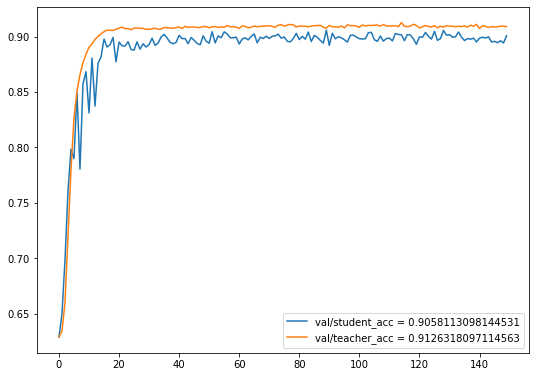

In [79]:
import matplotlib.pyplot as plt
import numpy as np

T=trainer.tensorboard.history

x = list(range(trainer.checkpoint.epoch_counter))
sm = lambda y, w: np.convolve(y, np.ones(w)/w, mode='same')
pp = lambda k: plt.plot(x, T[k], label=f"{k} = {max(T[k])}")
spp = lambda k: plt.plot(x, sm(T[k], 5), label=f"{k} = {max(T[k])}")


plt.figure(0, figsize=(30, 14))
plt.subplot(2, 3, 1)
pp("val/student_acc")
pp("val/teacher_acc")
plt.legend()

# plt.subplot(2, 3, 2)
# pp("hyperparameters/learning_rate")
# plt.legend()

# plt.subplot(2, 3, 3)
# pp("max/student_acc")
# pp("max/teacher_acc")
# plt.legend()

plt.show()

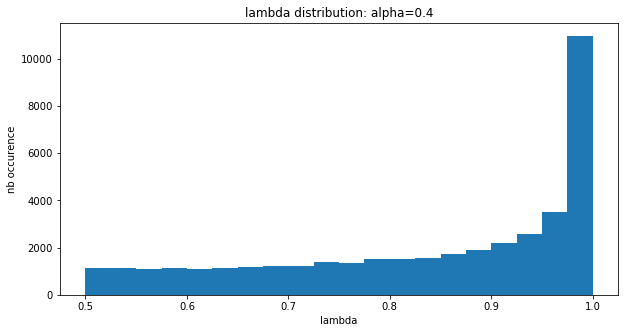

In [81]:
plt.figure(0, figsize=(10, 5))
plt.hist(trainer.mixup_fn.lambda_history, bins=20)
plt.ylabel("nb occurence")
plt.xlabel("lambda")
plt.title("lambda distribution: alpha=0.4")
plt.show()

# Test

In [45]:
trainer.checkpoint.load_best()

# aliases
M = self.metrics
T = self.tensorboard.add_scalar
nb_batch = len(self.val_loader)

start_time = time.time()
print("")

self.reset_metrics()
self.student.eval()

with torch.set_grad_enabled(False):
    for i, (X, y) in enumerate(self.test_loader):
        X = X.cuda()
        y = y.cuda()

        # Predictions
        with autocast(enabled=False):
            student_logits = self.student(X)
            teacher_logits = self.teacher(X)

            # Calculate supervised loss (only student on S)
            loss = self.loss_ce(student_logits, y)
            _teacher_loss = self.loss_ce(teacher_logits, y)  # for metrics only
            ccost = self.loss_cc(
                self.softmax_fn(student_logits),
                self.softmax_fn(teacher_logits))

        # Compute the metrics
        fscores, accs = self._calc_metrics(
            student_logits, student_logits, 
            teacher_logits, teacher_logits,
            y, y
        )

        # Running average of the two losses
        student_running_loss = M.avg_Sce(loss.item()).mean
        teacher_running_loss = M.avg_Tce(_teacher_loss.item()).mean
        running_ccost = M.avg_ccost(ccost.item()).mean

        # logs
        print(self.val_form.format(
            "Validation: ", epoch + 1, int(100 * (i + 1) / nb_batch),
            "", student_running_loss, running_ccost, accs.ss, fscores.ss, 0.0, 0.0,
            "", teacher_running_loss, accs.ts, fscores.ts, 0.0, 0.0,
            time.time() - start_time
        ), end="\r")

NameError: name 'self' is not defined

# Cross validation

training_params=DotDict(
    dataset=args.dataset,

    dataset_root = args.dataset_root,
    supervised_ratio = args.supervised_ratio,
    batch_size = args.batch_size,
    train_folds = args.train_folds,
    val_folds = args.val_folds,
    learning_rate=args.learning_rate,
    nb_epoch=args.nb_epoch,
    seed=args.seed,

)
other_params = dict(
    num_workers=0,
    pin_memory=True,
    verbose = 2,
)

train_folds = [
    [1, 2, 3, 4],
    [2, 3, 4, 5],
    [3, 4, 5, 1],
    [4, 5, 1, 2],
    [5, 1, 2, 3]
]

history = []
val_folds = [[5], [1], [2], [3], [4]]

for t, v in zip(train_folds, val_folds):
    print(t, v)

    mixup_fn = get_mixup_fn(alpha=1.5)
    trainer.mixup_fn = MethodType(mixup_fn, trainer)

    training_params.train_folds = t
    training_params.val_folds = v

    trainer.init_trainer(training_params, **other_params)
    trainer.set_printing_form()
    trainer.fit()

    history.append(((t, v), trainer.maximum_tracker))

    trainer.close()

for folds, maxer in history:
    print(folds, maxer.max["student_acc"].item(), maxer.max["teacher_acc"].item())

import numpy as np
    
s_acc = lambda x: x.max["student_acc"].item()
t_acc = lambda x: x.max["teacher_acc"].item()
maxers = [i[1] for i in history]

print("student accuracy mean + std")
print(np.mean(list(map(s_acc, maxers))), np.std(list(map(s_acc, maxers))))

print("teacher accuracy mean + std")
print(np.mean(list(map(t_acc, maxers))), np.std(list(map(t_acc, maxers))))

# Grid search

train_folds = [1, 2, 3, 4]
val_folds = [5]
alpha=(0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0, 1.5, 2)
history = []

for a in alpha:
    print(a)

    mixup_fn = get_mixup_fn(alpha=a)
    trainer.mixup_fn = MethodType(mixup_fn, trainer)

    training_params.train_folds = train_folds
    training_params.val_folds = val_folds

    trainer.init_trainer(training_params, **other_params)
    trainer.set_printing_form()
    trainer.fit()

    history.append((a, trainer.maximum_tracker))

    trainer.close()

for i, h in enumerate(history):
    print(alpha[i], s_acc(h[1]), t_acc(h[1]))

with open(".tmp.txt", "w") as f:
    f.write("learning_rate, lambda_ccost, ema_alpha, noise_db, acc_s, acc_t\n")
    for key, value in history:
        line = ", ".join(map(str, key)) + \
            ", " + "%s" % value.max["student_acc"].item() + \
            ", " + "%s" % value.max["teacher_acc"].item() + \
            "\n"
        f.write(line)
        print(line)


import matplotlib.pyplot as plt
import numpy as np

T = trainer.tensorboard.history
x = list(range(trainer.checkpoint.epoch_counter))
sm = lambda y, w: np.convolve(y, np.ones(w)/w, mode='same')
pp = lambda k: plt.plot(x, T[k], label=f"{k} = {max(T[k])}")
spp = lambda k: plt.plot(x, sm(T[k], 5), label=f"{k} = {max(T[k])}")


plt.figure(0, figsize=(30, 14))
plt.subplot(2, 3, 1)
pp("max/student_acc")
pp("max/teacher_acc")
plt.legend()

plt.subplot(2, 3, 3)
pp("hyperparameters/learning_rate")
plt.legend()

plt.show()